# Customer.io Engagement Analysis Tutorial

This notebook demonstrates a complete tutorial using simulated Customer.io engagement data. The project focuses on **event data analysis, spike detection, forecasting, and anomaly detection** through Python.

## Description

- The notebook imports data using a custom utility function `retrieve_event_summary()` that loads simulated user event logs.
- Daily and weekly aggregations are performed to understand user engagement patterns across three event types: `email_opened`, `clicked`, and `app_login`.
- Visualization of trends, detection of high-activity spikes, and anomaly detection via Z-score are demonstrated.
- ARIMA forecasting is applied to model short-term future trends in user behavior.

## References

- [Customerio.example.md](./Customerio.example.md) — Companion markdown file describing API limitations and simulated data setup.
- [Customerio_utils.py](./Customerio_utils.py) — Script to simulate and upload user/event data using the Customer.io API.

## Citations

- Customer.io Python SDK Documentation: https://customer.io/docs/api/
- ARIMA modeling: Box, G.E.P., Jenkins, G.M., & Reinsel, G.C. (2008). *Time Series Analysis: Forecasting and Control*.

## Notebook Flow

1. **Data Retrieval** – Load event logs from a local CSV via a utility.
2. **Aggregation** – Resample data to daily and weekly frequency.
3. **Visualization** – Plot event counts over time.
4. **Spike Detection** – Use statistical thresholds to flag anomalies.
5. **Forecasting** – Apply ARIMA for short-term trend forecasting.
6. **Evaluation** – Print MAE and RMSE for forecast accuracy.
7. **Anomaly Detection** – Highlight significant deviations using Z-score.

## Comments and Code Style

- All code is **imperatively commented** (e.g., *"Plot the daily event counts."*).
- Utility functions and constants are **clearly modularized** in an external script.
- Variable naming and structure follow best practices for readability and reproducibility.

---

This notebook is designed to reflect a real-world use case where direct data retrieval from an API is restricted. Therefore, a **data simulation and upload layer** is incorporated to allow for meaningful analysis of behavioral trends in a privacy-compliant setting.

In [1]:
from Customerio_utils import retrieve_event_summary, forecast_arima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import zscore

# Retrieve customer.io daily user data

In [2]:
summary_df = retrieve_event_summary()
summary_df.head()

event_name,app_login,clicked,email_opened
date,,,
2024-11-01,76,78,86
2024-11-02,72,91,79
2024-11-03,76,78,96
2024-11-04,87,95,91
2024-11-05,89,81,75


# Aggregate Weekly Counts

In [3]:
summary_df.index = pd.to_datetime(summary_df.index)
weekly_summary = summary_df.resample("W").sum()
weekly_summary.head()

event_name,app_login,clicked,email_opened
date,,,
2024-11-03,224,247,261
2024-11-10,588,607,592
2024-11-17,584,595,591
2024-11-24,592,572,633
2024-12-01,599,611,614


# Visualize Daily and Weekly Trends

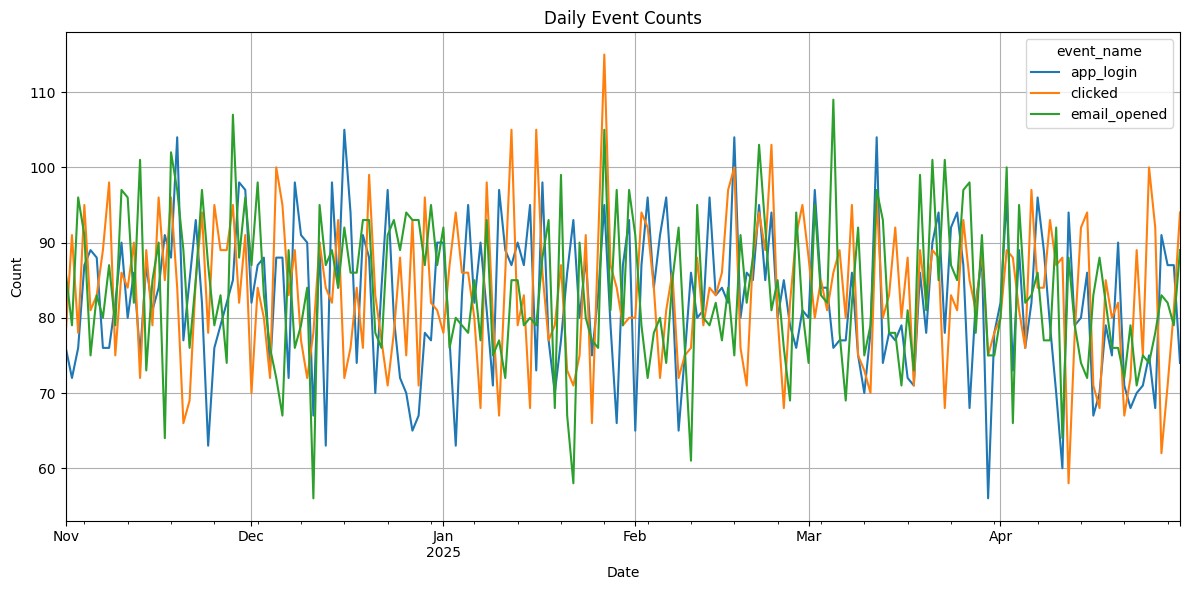

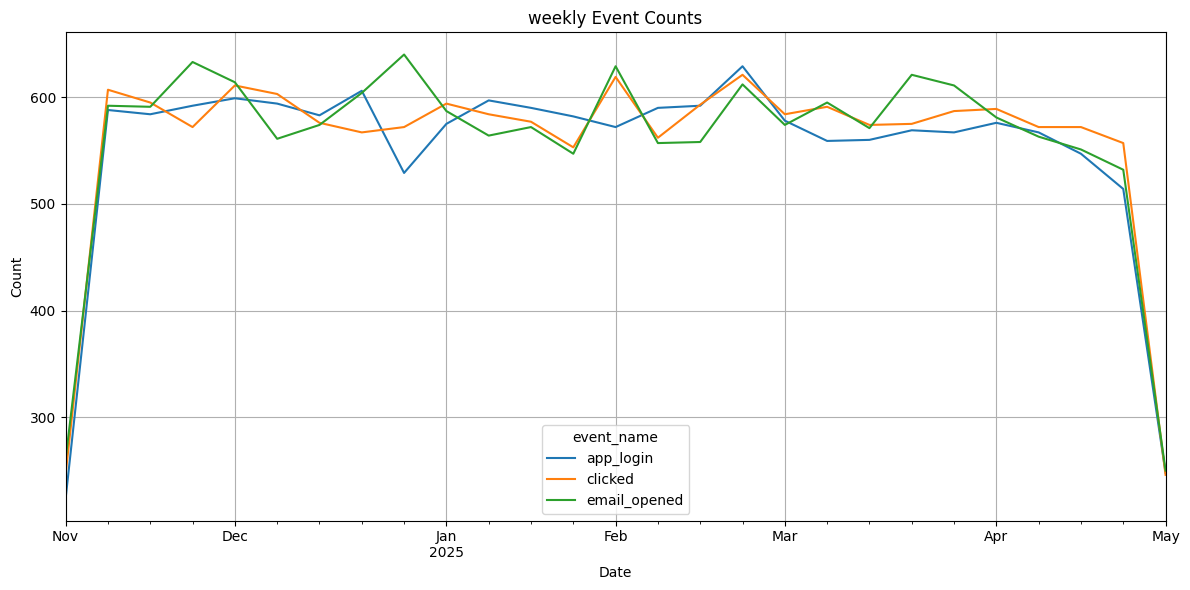

In [4]:
summary_df.plot(figsize=(12, 6), title="Daily Event Counts")
plt.xlabel("Date")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

weekly_summary.plot(figsize=(12, 6), title="weekly Event Counts")
plt.xlabel("Date")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

### Key Observations

- **Fluctuations are high**: Each event type varies substantially day to day, with noticeable spikes and dips — suggesting dynamic user behavior.

- **No clear trend**: There is no obvious upward or downward trajectory for any of the event types. The activity appears fairly stable but noisy.

- **Event volume ranges**: Most events fluctuate between **60 and 110 counts per day**.

- **Correlation**: Some overlap between the `clicked` and `email_opened` patterns implies a possible linkage — for example, emails being opened may lead to clicks.

# Detect Campaign Spikes (Basic Trend Insight)

### Spike Detection Method — Threshold Calculation

The spike detection threshold for `email_opened` events was defined using a simple statistical approach:
mean + 2 × std

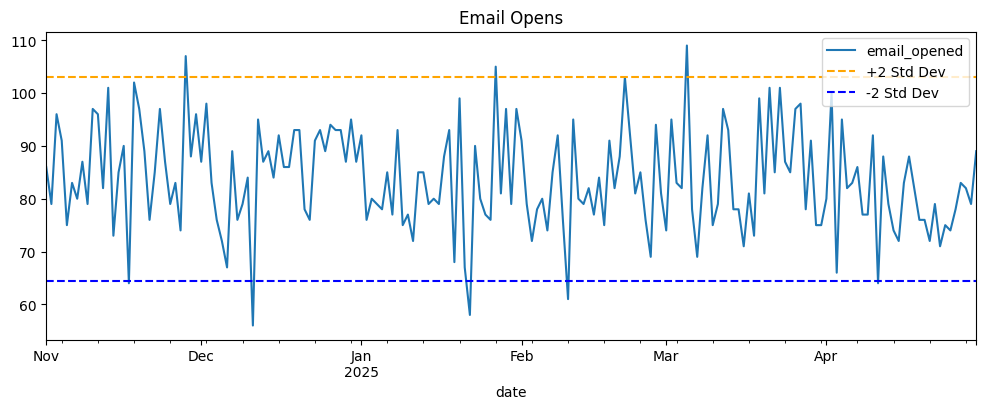

Upper Threshold (+2 std): 103.01
Lower Threshold (-2 std): 64.34

High Spike Dates (> +2 std):
2024-11-28
2025-01-27
2025-03-05

Low Spike Dates (< -2 std):
2024-11-17
2024-12-11
2025-01-22
2025-02-10
2025-04-11


In [6]:
summary_df["email_opened"].plot(figsize=(12, 4), title="Email Opens")
mean_val = summary_df["email_opened"].mean()
std_val = summary_df["email_opened"].std()

upper_threshold = mean_val + 2 * std_val
lower_threshold = mean_val - 2 * std_val

plt.axhline(upper_threshold, color='orange', linestyle='--', label='+2 Std Dev')
plt.axhline(lower_threshold, color='blue', linestyle='--', label='-2 Std Dev')
plt.legend()
plt.show()

# Print thresholds
print(f"Upper Threshold (+2 std): {upper_threshold:.2f}")
print(f"Lower Threshold (-2 std): {lower_threshold:.2f}")

# Identify spike dates
high_spike_dates = summary_df[summary_df["email_opened"] > upper_threshold].index
low_spike_dates = summary_df[summary_df["email_opened"] < lower_threshold].index

# Print spike dates
print("\nHigh Spike Dates (> +2 std):")
for date in high_spike_dates:
    print(date.strftime("%Y-%m-%d"))

print("\nLow Spike Dates (< -2 std):")
for date in low_spike_dates:
    print(date.strftime("%Y-%m-%d"))

#### Key Observations
- **Overall Activity Range**: Daily email opens fluctuate between ~65 and 105, showing regular variation.
- **Spike Threshold**: Set just above 100; values exceeding this line are considered spikes.
- **Detected Spikes**:
  - `2024-11-28`
  - `2025-01-27`
  - `2025-03-05`

These dates reflect **unusual surges in user engagement**, potentially caused by marketing campaigns, product announcements, or other impactful events.

---

#### Insights
- The engagement is generally stable but shows **four statistically significant spikes** across the time period.
- These anomalies may indicate **effective campaign days** worth further analysis to replicate or understand what drove the interaction.

#  Forecasting with ARIMA

email_opened — MAE: 6.20, RMSE: 7.14


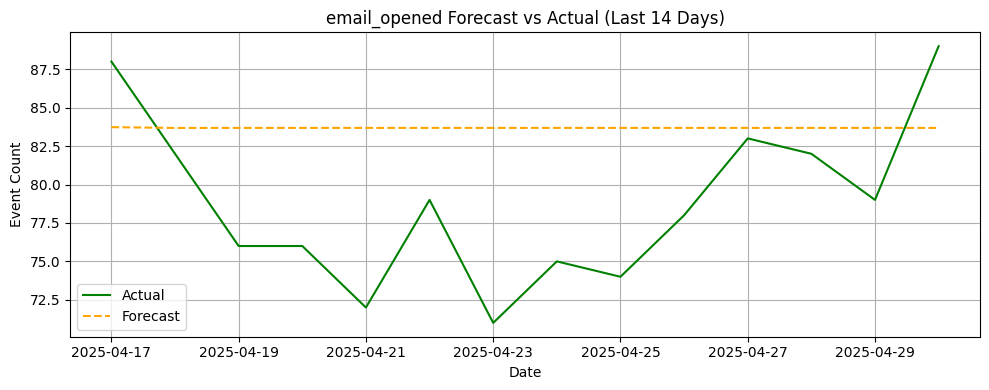

app_login — MAE: 9.32, RMSE: 10.02


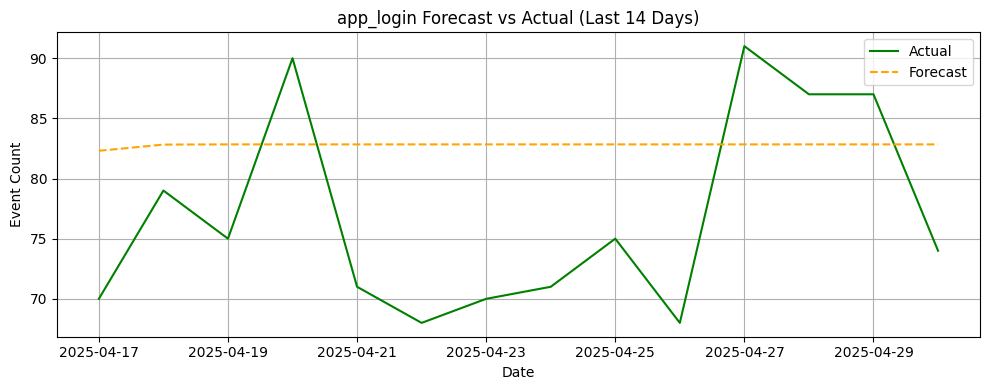

clicked — MAE: 9.82, RMSE: 11.61


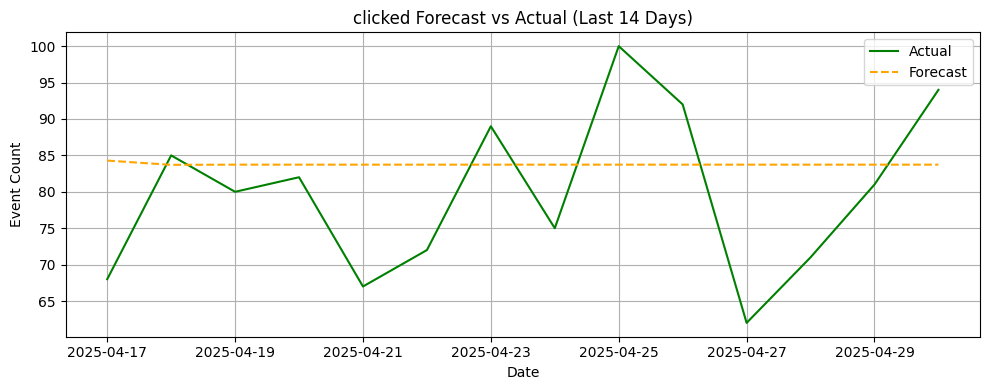

In [7]:
# Run forecasting
results = forecast_arima(summary_df)

# Evaluate and plot
for event, data in results.items():
    mae = mean_absolute_error(data["y_true"], data["y_pred"])
    rmse = np.sqrt(mean_squared_error(data["y_true"], data["y_pred"]))
    print(f"{event} — MAE: {mae:.2f}, RMSE: {rmse:.2f}")

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(data["dates"], data["y_true"], label="Actual", color="green")
    plt.plot(data["dates"], data["y_pred"], label="Forecast", color="orange", linestyle="--")
    plt.title(f"{event} Forecast vs Actual (Last {len(data['dates'])} Days)")
    plt.xlabel("Date")
    plt.ylabel("Event Count")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### ARIMA Forecast Results for Last 14 Days

This section evaluates how well the ARIMA model predicted event counts for the last two weeks for each event type: `email_opened`, `app_login`, and `clicked`. We use **MAE**, **RMSE**, and visual comparisons to assess performance.

---

#### 1. `email_opened`
- **MAE**: 6.20  
- **RMSE**: 7.14  
- **Observation**:
  - The forecast (flat line near 83.5) fails to capture dynamic fluctuations in user activity.
  - The actual data varies significantly, especially in the second week.
- **Insight**:  
    ARIMA underfits — unable to track trends and spikes. Performance is decent but could be improved with seasonal components or adaptive models.

---

#### 2. `app_login`
- **MAE**: 9.32  
- **RMSE**: 10.02  
- **Observation**:
  - Forecast remains slightly increasing but mostly flat.
  - Actual behavior is highly volatile, with spikes (e.g., 90+) and dips (~68).
- **Insight**:  
    Poor accuracy — the model fails to capture the instability in user login patterns.

---

#### 3. `clicked`
- **MAE**: 9.82  
- **RMSE**: 11.61  
- **Observation**:
  - The forecast again stays stable (~84), but real data shows sharp jumps (up to 100) and deep drops (near 63).
- **Insight**:  
   Worst fit — the model performs poorly due to high variance and outliers in click behavior.

---

### Summary Table

| Event         | MAE   | RMSE  | Forecast Fit |
|---------------|-------|-------|-------------------------|
| email_opened  | 6.20  | 7.14  |    Moderate             |
| app_login     | 9.32  | 10.02 |    Poor                 |
| clicked       | 9.82  | 11.61 |    Very poor            |




# Anomaly Detection (Simple Z-score or Threshold)

### This table lists dates where `email_opened` counts were identified as anomalies using **Z-score analysis**.

In [8]:
summary_df["zscore_email"] = zscore(summary_df["email_opened"])
anomalies = summary_df[summary_df["zscore_email"].abs() > 2]

print("Anomalies Detected:")
print(anomalies[["email_opened", "zscore_email"]])

Anomalies Detected:
event_name  email_opened  zscore_email
date                                  
2024-11-17            64     -2.040905
2024-11-28           107      2.419741
2024-12-11            56     -2.870792
2025-01-22            58     -2.663320
2025-01-27           105      2.212269
2025-02-10            61     -2.352112
2025-02-21           103      2.004798
2025-03-05           109      2.627213
2025-04-11            64     -2.040905



### Observations

- **High Spikes**: 
  - Days like `2024-11-28`, `2025-01-27`, and `2025-03-05` reflect **campaign surges** or unusually successful email pushes.
  - These are potential best practices worth replicating in future marketing efforts.

- **Sharp Drops**: 
  - Days like `2024-12-11` and `2025-01-22` indicate **poor engagement**, possibly due to timing, content issues, or external factors.

---

#### Takeaways

- Monitoring anomalies helps uncover **high-impact days** (positive or negative) that deviate from expected user behavior.
- Use these dates to investigate campaign content, delivery time, or audience segmentation strategies that led to success or failure.